In [2]:
import time
import numpy as np
import math


In [3]:
#@title Implementación con objeto Vectores 3D


# Constantes del problema físico
N = 2
G = 1.0

# Constantes del algoritmo de integración
xi = 0.1786178958448091
lambda_val = -0.2123418310626054
chi = -0.06626458266981849
Um2lambdau2 = (1 - 2 * lambda_val) / 2
Um2chiplusxi = 1 - 2 * (chi + xi)

# Declarar la clase Vector3D
class Vector3D:
    def __init__(self, x, y, z):
        self.x_val = x
        self.y_val = y
        self.z_val = z

    def load(self, x, y, z):
        self.x_val = x
        self.y_val = y
        self.z_val = z

    def norm2(self):
        return self.x_val**2 + self.y_val**2 + self.z_val**2

# Declarar la clase Cuerpo
class Cuerpo:
    def __init__(self):
        self.r = Vector3D(0, 0, 0)
        self.V = Vector3D(0, 0, 0)
        self.F = Vector3D(0, 0, 0)
        self.m = 0
        self.R = 0

    def inicie(self, x0, y0, z0, Vx0, Vy0, Vz0, m0, R0):
        self.r.load(x0, y0, z0)
        self.V.load(Vx0, Vy0, Vz0)
        self.m = m0
        self.R = R0

    def borre_fuerza(self):
        self.F.load(0, 0, 0)

    def sume_fuerza(self, dF):
        self.F.x_val += dF.x_val
        self.F.y_val += dF.y_val
        self.F.z_val += dF.z_val

    def mueva_r(self, dt, coeficiente):
        self.r.x_val += self.V.x_val * (coeficiente * dt)
        self.r.y_val += self.V.y_val * (coeficiente * dt)
        self.r.z_val += self.V.z_val * (coeficiente * dt)

    def mueva_V(self, dt, coeficiente):
        self.V.x_val += self.F.x_val * (coeficiente * dt / self.m)
        self.V.y_val += self.F.y_val * (coeficiente * dt / self.m)
        self.V.z_val += self.F.z_val * (coeficiente * dt / self.m)

    def dibujese(self):
        return ", {0}+{1}*cos(t), {2}+{3}*sin(t)".format(
            self.r.x_val, self.R, self.r.y_val, self.R)

    def get_x(self):
        return self.r.x_val

    def get_y(self):
        return self.r.y_val


# Declarar la clase Colisionador
class Colisionador:
    def calcule_todas_las_fuerzas(self, planetas):
        for i in range(N):
            planetas[i].borre_fuerza()

        for i in range(N):
            for j in range(i):
                self.calcule_fuerza_entre(planetas[i], planetas[j])

    def calcule_fuerza_entre(self, planeta1, planeta2):
        m1, m2 = planeta1.m, planeta2.m
        r21 = Vector3D(planeta2.r.x_val - planeta1.r.x_val,
                       planeta2.r.y_val - planeta1.r.y_val,
                       planeta2.r.z_val - planeta1.r.z_val)
        r2 = r21.norm2()
        aux = G * m2 * m1 * r2**(-1.5)
        F1 = Vector3D(r21.x_val * aux, r21.y_val * aux, r21.z_val * aux)
        planeta1.sume_fuerza(F1)
        planeta2.sume_fuerza(Vector3D(-F1.x_val, -F1.y_val, -F1.z_val))


# Funciones de animación
def inicie_animacion():
    return """
    unset key
    set xrange[-11:11]
    set yrange[-11:11]
    set size ratio -1
    set parametric
    set trange [0:7]
    set isosamples 12
    """


def inicie_cuadro():
    return "plot 0,0 "


def termine_cuadro():
    return ""


if __name__ == "__main__":
    r = 11
    m0, m1 = 10, 1
    M = m0 + m1
    mu = m0 * m1 / M
    x0 = -m1 * r / M
    x1 = m0 * r / M
    omega = math.sqrt(G * M / (r**3))
    T = 2 * math.pi / omega
    V0 = omega * x0
    V1 = omega * x1
    t, dt, Nc = 0, 0.1, 0
    ttotal = T
    Ncuadros = 30000
    tdibujo, tcuadro = 0, ttotal / Ncuadros

    planetas = [Cuerpo() for _ in range(N)]
    newton = Colisionador()


    inicie_animacion()

    # INICIO
    planetas[0].inicie(x0, 0, 0, 0, 0.5 * V0, 0, m0, 1.0)
    planetas[1].inicie(x1, 0, 0, 0, 0.5 * V1, 0, m1, 0.5)

    tiempo = np.zeros(int(ttotal/dt) + 1)


    with open("data.txt",'w') as archivo:
        inicio = time.time()

        # CORRO
        while t < ttotal:
            if t > tcuadro:
                archivo.write(inicie_cuadro())
                for i in range(N):
                    archivo.write(planetas[i].dibujese())
                archivo.write(inicie_cuadro())

                t = 0
            # p1x =  str(planetas[1].get_x())
            # p1y = str(planetas[1].get_y())
            # contenido_p1 = p1x +"\t"+ p1y + "\n"
            # archivo.write(contenido_p1)
            #print(contenido_p1)

            for i in range(N):planetas[i].mueva_r(dt, xi)
            newton.calcule_todas_las_fuerzas(planetas)
            for i in range(N):planetas[i].mueva_V(dt, Um2lambdau2)

            for i in range(N):planetas[i].mueva_r(dt, chi)
            newton.calcule_todas_las_fuerzas(planetas)
            for i in range(N):planetas[i].mueva_V(dt, lambda_val)

            for i in range(N):planetas[i].mueva_r(dt, Um2chiplusxi)
            newton.calcule_todas_las_fuerzas(planetas)
            for i in range(N):planetas[i].mueva_V(dt, lambda_val)


            for i in range(N):planetas[i].mueva_r(dt, chi)
            newton.calcule_todas_las_fuerzas(planetas)
            for i in range(N):planetas[i].mueva_V(dt, Um2lambdau2)


            for i in range(N):planetas[i].mueva_r(dt, xi)
            fin = time.time()
            tiempo_total = fin - inicio
            tiempo[Nc] = tiempo_total
            Nc += 1
            t += dt
print(f"Tiempo promedio de ejecución: {tiempo.mean():.4f} segundos")

IndexError: index 692 is out of bounds for axis 0 with size 692

Text(0, 0.5, 'Tiempo por iteracion (s)')

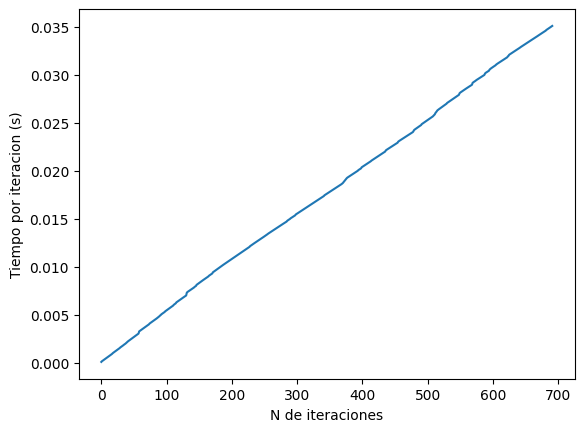

In [ ]:
import matplotlib.pyplot as plt

plt.plot(tiempo)
plt.xlabel("N de iteraciones")
plt.ylabel("Tiempo por iteracion (s)")

In [ ]:
%%shell
gnuplot data.txt

%%cmd
gnuplot data.txt

In [25]:
#@title Implementación con numpy


# Constantes del problema físico
N = 2
G = 1.0

# Constantes del algoritmo de integración
xi = 0.1786178958448091
lambda_val = -0.2123418310626054
chi = -0.06626458266981849
Um2lambdau2 = (1 - 2 * lambda_val) / 2
Um2chiplusxi = 1 - 2 * (chi + xi)

# Declarar la clase Cuerpo
class Cuerpo:
    def __init__(self):
        self.r = np.array((0,0,0))
        self.V = np.array((0,0,0))
        self.F = np.array((0,0,0))
        self.m = 0
        self.R = 0

    def inicie(self, x0, y0, z0, Vx0, Vy0, Vz0, m0, R0):
        self.r[:] =x0, y0, z0
        self.V[:] =Vx0, Vy0, Vz0
        self.m = m0
        self.R = R0

    def borre_fuerza(self):
        self.F = np.array((0,0,0))

    def sume_fuerza(self, dF):
        self.F[0] += dF[0]
        self.F[1] += dF[1]
        self.F[2] += dF[2]

    def mueva_r(self, dt, coeficiente):
        self.r[0] += self.V[0] * (coeficiente * dt)
        self.r[1] += self.V[1] * (coeficiente * dt)
        self.r[2] += self.V[2] * (coeficiente * dt)


    def mueva_V(self, dt, coeficiente):
        self.V[0] += self.F[0] * (coeficiente * dt / self.m)
        self.V[1] += self.F[1] * (coeficiente * dt / self.m)
        self.V[2] += self.F[2] * (coeficiente * dt / self.m)


    def dibujese(self):
        return " , {0}+{1}*cos(t),{2}+{3}*sin(t)".format(
            self.r[0], self.R, self.r[1], self.R)

    def get_x(self):
        return self.r[0]

    def get_y(self):
        return self.r[0]


# Declarar la clase Colisionador
class Colisionador:
    def calcule_todas_las_fuerzas(self, planetas):
        for i in range(N):
            planetas[i].borre_fuerza()

        for i in range(N):
            for j in range(i):
                #if i<j:
                self.calcule_fuerza_entre(planetas[i], planetas[j])

    def calcule_fuerza_entre(self, planeta1, planeta2):
        m1, m2 = planeta1.m, planeta2.m
        r21 = np.array((planeta2.r[0] - planeta1.r[0],
                       planeta2.r[1] - planeta1.r[1],
                       planeta2.r[2] - planeta1.r[2]))
        r2 = np.linalg.norm(r21)
        aux = G * m2 * m1 * r2
        F1 = r21*aux
        planeta1.sume_fuerza(F1)
        planeta2.sume_fuerza(-1*F1)


# Funciones de animación
def inicie_animacion():
    return """
set terminal gif animate
set output 'planetas.gif'
unset key
set xrange[-11:11]
set yrange[-11:11]
set size ratio -1
set parametric
set trange [0:7]
set isosamples 12
"""


def inicie_cuadro():
    return "plot 0,0 "


def termine_cuadro():
    return "\n"


if __name__ == "__main__":
    r = 11
    m0, m1 = 10, 1
    M = m0 + m1
    mu = m0 * m1 / M
    x0 = -m1 * r / M
    x1 = m0 * r / M
    omega = math.sqrt(G * M / (r**3))
    T = 2 * math.pi / omega
    V0 = omega * x0
    V1 = omega * x1
    t, tdibujo, Nc, dt = 0, 0, 0, 0.1
    ttotal = T
    Ncuadros = 30000
    tdibujo, tcuadro = 0, ttotal / Ncuadros


    planetas = [Cuerpo() for _ in range(N)]
    newton = Colisionador()

    with open("data1.txt",'w') as archivo:
        
        archivo.write(inicie_animacion())

        # INICIO
        planetas[0].inicie(x0, 0, 0, 0, 0.5 * V0, 0, m0, 1.0)
        planetas[1].inicie(x1, 0, 0, 0, 0.5 * V1, 0, m1, 0.5)

        tiempo = np.zeros(int(ttotal/dt) + 1)
    
        inicio = time.time()
        # CORRO
        while t < ttotal:


            if tdibujo> tcuadro:
                archivo.write(inicie_cuadro())
                fila_planetas=""
                for i in range(N):
                    fila_planetas += planetas[i].dibujese() 
                archivo.write(fila_planetas)
                archivo.write(termine_cuadro())

                tdibujo = 0
            # p1x =  str(planetas[1].get_x())
            # p1y = str(planetas[1].get_y())
            # contenido_p1 = p1x +"\t"+ p1y + "\n"
            # archivo.write(contenido_p1)
            #print(contenido_p1)

            for i in range(N):planetas[i].mueva_r(dt, xi)
            newton.calcule_todas_las_fuerzas(planetas)
            for i in range(N):planetas[i].mueva_V(dt, Um2lambdau2)

            for i in range(N):planetas[i].mueva_r(dt, chi)
            newton.calcule_todas_las_fuerzas(planetas)
            for i in range(N):planetas[i].mueva_V(dt, lambda_val)

            for i in range(N):planetas[i].mueva_r(dt, Um2chiplusxi)
            newton.calcule_todas_las_fuerzas(planetas)
            for i in range(N):planetas[i].mueva_V(dt, lambda_val)


            for i in range(N):planetas[i].mueva_r(dt, chi)
            newton.calcule_todas_las_fuerzas(planetas)
            for i in range(N):planetas[i].mueva_V(dt, Um2lambdau2)


            for i in range(N):planetas[i].mueva_r(dt, xi)

            fin = time.time()
            tiempo_total = fin - inicio
            tiempo[Nc] = tiempo_total
            Nc += 1
            t += dt
            tdibujo += dt

print(f"Tiempo promedio de ejecución: {tiempo.mean():.4f} segundos")

Tiempo promedio de ejecución: 0.0693 segundos


In [26]:
print(tcuadro,ttotal)

0.002303834612632515 69.11503837897544


Text(0, 0.5, 'Tiempo por iteracion (s)')

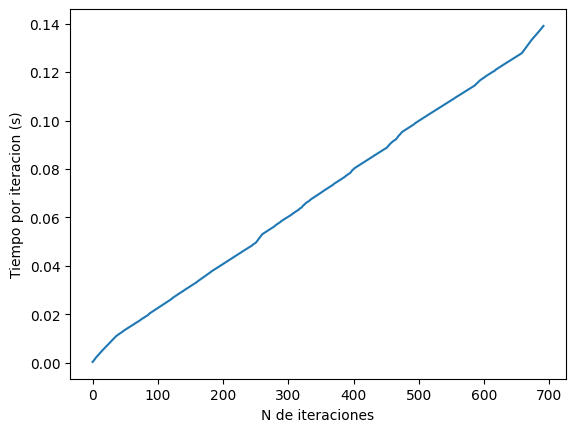

In [27]:
import matplotlib.pyplot as plt

plt.plot(tiempo)
plt.xlabel("N de iteraciones")
plt.ylabel("Tiempo por iteracion (s)")

In [28]:
%%shell
gnuplot data.txt

# %%cmd
# gnuplot data.txt



UsageError: Cell magic `%%shell` not found.
